In [ ]:
!pip install git+https://github.com/pabloppp/Arroz-Con-Cosas

In [1]:
import os
import time
import torch
import yaml
import json
import tqdm
from glob import glob
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
from os.path import exists
import math
import webdataset as wds
import pytorch_lightning as pl
from webdataset.handlers import warn_and_continue
from modules import DenoiseUNet
import open_clip
from open_clip import tokenizer
from rudalle import get_vae
from einops import rearrange
from arroz import Diffuzz, PriorModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

def showimages(imgs, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 32), kwargs.get("height", 32)))
    plt.axis("off")
    plt.imshow(torch.cat([
        torch.cat([i for i in imgs], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()
    
def saveimages(imgs, name, **kwargs):
    name = name.replace(" ", "_").replace(".", "")
    path = os.path.join("outputs", name + ".jpg")
    while os.path.exists(path):
        base, ext = path.split(".")
        num = base.split("_")[-1]
        if num.isdigit():
            num = int(num) + 1
            base = "_".join(base.split("_")[:-1])
        else:
            num = 0
        path = base + "_" + str(num) + "." + ext
    torchvision.utils.save_image(imgs, path, **kwargs)

/fsx/mas/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on: cuda:0


In [2]:
def log(t, eps=1e-20):
    return torch.log(t + eps)

def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -log(-log(noise))

def gumbel_sample(t, temperature=1., dim=-1):
    return ((t / max(temperature, 1e-10)) + gumbel_noise(t)).argmax(dim=dim)

def sample(model, c, x=None, negative_embeddings=None, mask=None, T=12, size=(32, 32), starting_t=0, temp_range=[1.0, 1.0], typical_filtering=True, typical_mass=0.2, typical_min_tokens=1, classifier_free_scale=-1, renoise_steps=11, renoise_mode='start'):
    with torch.inference_mode():
        r_range = torch.linspace(0, 1, T+1)[:-1][:, None].expand(-1, c.size(0)).to(c.device)
        temperatures = torch.linspace(temp_range[0], temp_range[1], T)
        preds = []
        if x is None:
            x = torch.randint(0, model.num_labels, size=(c.size(0), *size), device=c.device)
        elif mask is not None:
            noise = torch.randint(0, model.num_labels, size=(c.size(0), *size), device=c.device)
            x = noise * mask + (1-mask) * x
        init_x = x.clone()
        for i in range(starting_t, T):
            if renoise_mode == 'prev':
                prev_x = x.clone()
            r, temp = r_range[i], temperatures[i]
            logits = model(x, c, r)
            if classifier_free_scale >= 0:
                if negative_embeddings is not None:
                    logits_uncond = model(x, negative_embeddings, r)
                else:
                    logits_uncond = model(x, torch.zeros_like(c), r)
                logits = torch.lerp(logits_uncond, logits, classifier_free_scale)
            x = logits
            x_flat = x.permute(0, 2, 3, 1).reshape(-1, x.size(1))
            if typical_filtering:
                x_flat_norm = torch.nn.functional.log_softmax(x_flat, dim=-1)
                x_flat_norm_p = torch.exp(x_flat_norm)
                entropy = -(x_flat_norm * x_flat_norm_p).nansum(-1, keepdim=True)

                c_flat_shifted = torch.abs((-x_flat_norm) - entropy)
                c_flat_sorted, x_flat_indices = torch.sort(c_flat_shifted, descending=False)
                x_flat_cumsum = x_flat.gather(-1, x_flat_indices).softmax(dim=-1).cumsum(dim=-1)

                last_ind = (x_flat_cumsum < typical_mass).sum(dim=-1)
                sorted_indices_to_remove = c_flat_sorted > c_flat_sorted.gather(1, last_ind.view(-1, 1))
                if typical_min_tokens > 1:
                    sorted_indices_to_remove[..., :typical_min_tokens] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, x_flat_indices, sorted_indices_to_remove)
                x_flat = x_flat.masked_fill(indices_to_remove, -float("Inf"))
            x_flat = torch.multinomial(x_flat.div(temp).softmax(-1), num_samples=1)[:, 0]
            # print(x_flat.shape)
            # x_flat = gumbel_sample(x_flat, temperature=temp)
            x = x_flat.view(x.size(0), *x.shape[2:])
            if mask is not None:
                x = x * mask + (1-mask) * init_x
            if i < renoise_steps:
                if renoise_mode == 'start':
                    x, _ = model.add_noise(x, r_range[i+1], random_x=init_x)
                elif renoise_mode == 'prev':
                    x, _ = model.add_noise(x, r_range[i+1], random_x=prev_x)
                else: # 'rand'
                    x, _ = model.add_noise(x, r_range[i+1])
            preds.append(x.detach())
    return preds

In [3]:
vqmodel = get_vae().to(device)
vqmodel.eval().requires_grad_(False)

clip_model, _, _ = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
clip_model = clip_model.to(device).eval().requires_grad_(False)

clip_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)),
])

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
])

def encode(x):
    return vqmodel.model.encode((2 * x - 1))[-1][-1]
    
def decode(img_seq, shape=(32,32)):
        img_seq = img_seq.view(img_seq.shape[0], -1)
        b, n = img_seq.shape
        one_hot_indices = torch.nn.functional.one_hot(img_seq, num_classes=vqmodel.num_tokens).float()
        z = (one_hot_indices @ vqmodel.model.quantize.embed.weight)
        z = rearrange(z, 'b (h w) c -> b c h w', h=shape[0], w=shape[1])
        img = vqmodel.model.decode(z)
        img = (img.clamp(-1., 1.) + 1) * 0.5
        return img
    
state_dict = torch.load("./models/Paella_1B_img/model.pt", map_location=device)
model = DenoiseUNet(num_labels=8192, c_clip=1024, c_hidden=1280, down_levels=[1, 2, 8, 32], up_levels=[32, 8, 2, 1]).to(device)
model.load_state_dict(state_dict)
model.eval().requires_grad_()

prior_path = "/fsx/home-pablo/models/arroz_con_cosas/prior_v1_1500k.pt"
prior_ckpt_full = torch.load(prior_path, map_location=device)
prior_ckpt = prior_ckpt_full["state_dict"]
prior = PriorModel().to(device)
prior.load_state_dict(prior_ckpt)
prior.eval().requires_grad_(False)
diffuzz = Diffuzz(device=device)

del prior_ckpt, prior_ckpt_full, state_dict

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/fsx/mas/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
Downloading: 100%|███████████████████████████████████████████████████████████████████| 346M/346M [00:05<00:00, 63.1MB/s]


vae --> ready


CLIP Embedding:  3.1037797927856445
Prior Sampling:  1.5130565166473389
Generator Sampling:  6.4151222705841064
A teddy bear wearing a nurse outfit, photorealistic style


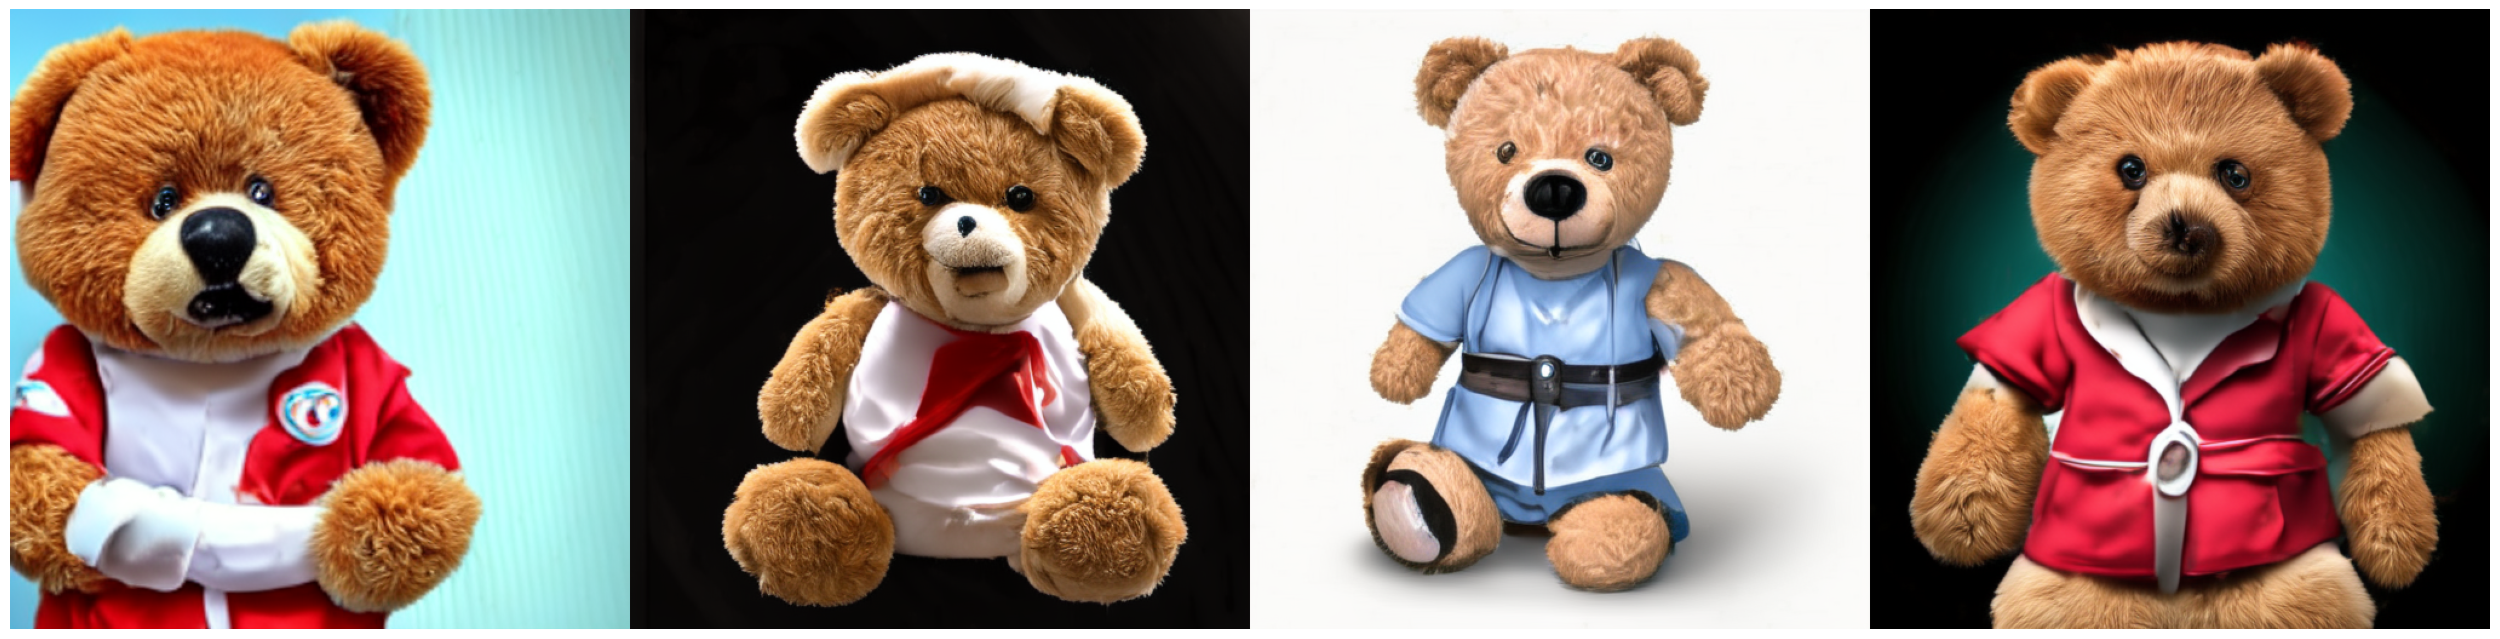

In [4]:
mode = "text"
batch_size = 4
caption = "A teddy bear wearing a nurse outfit, photorealistic style"
negative_caption = "blurry, low resolution, low definition, watermark, repeating"
latent_shape = (64, 64)

prior_timesteps = 60
prior_cfg = 3.0
prior_sampler = 'ddpm'
clip_embedding_shape = (batch_size, 1024)

generator_timesteps = 12

text = tokenizer.tokenize([caption] * batch_size).to(device)
negative_text = tokenizer.tokenize([negative_caption] * batch_size).to(device)
with torch.inference_mode():
    with torch.autocast(device_type="cuda"):
        s = time.time()
        text_embeddings = clip_model.encode_text(text)
        negative_text_embeddings = clip_model.encode_text(negative_text)
        print("CLIP Embedding: ", time.time() - s)
        
        s = time.time()
        sampled_image_embeddings = diffuzz.sample(
            prior, {'c': text_embeddings}, clip_embedding_shape,
            timesteps=prior_timesteps, cfg=prior_cfg, sampler=prior_sampler
        )[-1]
        print("Prior Sampling: ", time.time() - s)
        
        s = time.time()
        sampled = sample(model, sampled_image_embeddings, negative_embeddings=negative_text_embeddings, T=generator_timesteps, size=latent_shape, starting_t=0, temp_range=[2.0, 0.1],
           typical_filtering=False, typical_mass=0.2, typical_min_tokens=1, classifier_free_scale=5, renoise_steps=generator_timesteps-1,
           renoise_mode="start")
        print("Generator Sampling: ", time.time() - s)
    sampled = decode(sampled[-1], latent_shape)

print(caption)
plt.figure(figsize=(32, 32))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in sampled.float().cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()
saveimages(sampled, mode + "_" + caption, nrow=len(sampled))